<a href="https://colab.research.google.com/github/GuyFarb/Cars-Project/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50,VGG19
from tensorflow.keras.layers import Dense ,GlobalAveragePooling2D,Dropout,GlobalMaxPool2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D


In [175]:
!ls "/content/drive/MyDrive/Car196_project/processed_cars196/"

 cars196_test.tfrecord	  labels.csv		 model_aug.keras   train_labels.csv
 cars196_train.tfrecord   model_1FU.keras	 test_images
'images (1).npy'	  model_1.keras		 test_labels.csv
 images.npy		  model_aug_fine.keras	 train_images


In [176]:
import tensorflow as tf
import os

def serialize_example(image, label):
    feature = {
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(tf.cast(image * 255, tf.uint8)).numpy()])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label.numpy()]))
    }
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    return example.SerializeToString()

In [177]:
# נתיבים לקובצי ה-TFRecord
tfrecord_train_path = "/content/drive/MyDrive/Car196_project/processed_cars196/cars196_train.tfrecord"
tfrecord_test_path = "/content/drive/MyDrive/Car196_project/processed_cars196/cars196_test.tfrecord"

# בדיקה אם הקובץ כבר קיים
if not os.path.exists(tfrecord_train_path) or not os.path.exists(tfrecord_test_path):
    print("⚠️ לא נמצא קובץ TFRecord – יוצרים אחד חדש...")

    with tf.io.TFRecordWriter(tfrecord_train_path) as writer:
        for image, label in train_dataset.unbatch():
            example = serialize_example(image, label)
            writer.write(example)

    with tf.io.TFRecordWriter(tfrecord_test_path) as writer:
        for image, label in test_dataset.unbatch():
            example = serialize_example(image, label)
            writer.write(example)

    print("✅ הקובץ נשמר בהצלחה!")
else:
    print("✅ נמצא קובץ TFRecord, לא נדרש ליצור מחדש.")

✅ נמצא קובץ TFRecord, לא נדרש ליצור מחדש.


In [178]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    image = tf.image.resize(image, (224, 224))  # שינוי גודל
    image = tf.cast(image, tf.float32) / 255.0  # נורמליזציה
    label = example["label"]
    return image, label

train_dataset = tf.data.TFRecordDataset(tfrecord_train_path).map(parse_tfrecord).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = tf.data.TFRecordDataset(tfrecord_test_path).map(parse_tfrecord).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [179]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # היפוך אופקי
    image = tf.image.random_brightness(image, max_delta=0.2)  # שינוי תאורה
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # קונטרסט
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)  # רווייה
    return image, label

train_dataset_augmented = train_dataset.map(augment).prefetch(tf.data.AUTOTUNE)

In [180]:
from itertools import product

# טווחים לבדיקה
brightness_values = [0.2]
contrast_values = [(0.8, 1.2), (0.7, 1.3),]
saturation_values = [(0.8, 1.2), (0.7, 1.3)]

best_accuracy = 0
best_params = {}

for brightness, contrast, saturation in product(brightness_values, contrast_values, saturation_values):
    print(f"🎯 בודק: Brightness={brightness}, Contrast={contrast}, Saturation={saturation}")

    train_dataset_augmented = train_dataset.map(lambda x, y: augment(x, y, brightness, contrast, saturation)).prefetch(AUTOTUNE)

    model = build_model(pooling_type="max", dropout_rate=0.4, dense_size=256)

    model.fit(train_dataset_augmented, validation_data=test_dataset, epochs=3, verbose=0)

    val_acc = model.evaluate(test_dataset, verbose=0)[1]
    print(f"🔍 דיוק על סט הבדיקה: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = {"brightness": brightness, "contrast": contrast, "saturation": saturation}

print(f"\n🔥 האוגמנטציה הטובה ביותר: {best_params}, דיוק: {best_accuracy:.4f}")

🎯 בודק: Brightness=0.2, Contrast=(0.8, 1.2), Saturation=(0.8, 1.2)


TypeError: in user code:

    File "<ipython-input-101-2ca9e0f3f037>", line 14, in None  *
        lambda x, y: augment(x, y, brightness, contrast, saturation)

    TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__augment() takes 2 positional arguments but 5 were given


In [181]:
# הוספת האוגמנטציות שנבחרו כטובות ביותר
train_dataset_augmented = (
    train_dataset
    .map(lambda x, y: augment(x, y), num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [182]:
for image_batch, label_batch in train_dataset.take(1):
    print(f"🔍 צורת ה-Image Batch: {image_batch.shape}")  # אמור להיות (32, 224, 224, 3)
    print(f"🔍 צורת ה-Label Batch: {label_batch.shape}")  # אמור להיות (32,)

🔍 צורת ה-Image Batch: (32, 224, 224, 3)
🔍 צורת ה-Label Batch: (32,)


In [183]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def build_model(pooling_type="max", dropout_rate=0.5, dense_size=1024):
    base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # מקפיאים את שכבות הבסיס

    x = base_model.output
    x = Conv2D(1024, (3,3), activation="relu", padding="same")(x)

    if pooling_type == "max":
        x = MaxPooling2D(pool_size=(2,2), strides=2)(x)
    else:
        x = AveragePooling2D(pool_size=(2,2), strides=2)(x)

    x = Flatten()(x)
    x = Dense(dense_size, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_size // 2, activation="relu")(x)
    x = Dropout(dropout_rate / 2)(x)
    x = Dense(196, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model

# בניית המודל
model = build_model(pooling_type="max", dropout_rate=0.4, dense_size=1024)

# בדיקת המבנה
model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 34,807,556 (132.78 MB)

 Trainable params: 14,783,172 (56.39 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [184]:
history = model.fit(
    train_dataset_augmented,
    validation_data=test_dataset,
    epochs=12
)

Epoch 1/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.0079 - loss: 5.3562 - val_accuracy: 0.0076 - val_loss: 5.2658
Epoch 2/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.0101 - loss: 5.2661 - val_accuracy: 0.0177 - val_loss: 5.2205
Epoch 3/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.0161 - loss: 5.1726 - val_accuracy: 0.0264 - val_loss: 4.8352
Epoch 4/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.0286 - loss: 4.8423 - val_accuracy: 0.0685 - val_loss: 4.4399
Epoch 5/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.0538 - loss: 4.4665 - val_accuracy: 0.1058 - val_loss: 4.0975
Epoch 6/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.0934 - loss: 4.1045 - val_accuracy: 0.1487 - val_loss: 3.7282
Epoch 7/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.1315 - loss: 3.7576 - val_accuracy: 0.1817 - val_loss: 3.4829
Epoch 8/12
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.1829 - loss: 3.4442 - 

In [185]:
# prompt: save the model

# שמירת המודל
model.save('/content/drive/MyDrive/Car196_project/real_model.keras')


In [199]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Car196_project/real_model.keras')

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.0400 - loss: 5.0844 - val_accuracy: 0.2010 - val_loss: 3.2980
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.2188 - loss: 3.1464 - val_accuracy: 0.3000 - val_loss: 2.7028
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.3569 - loss: 2.4107 - val_accuracy: 0.4343 - val_loss: 2.1000
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.4440 - loss: 1.9569 - val_accuracy: 0.4695 - val_loss: 1.9199
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.5385 - loss: 1.6233 - val_accuracy: 0.5287 - val_loss: 1.7195
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.5906 - loss: 1.4153 - val_accuracy: 0.5661 - val_loss: 1.5227
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.6474 - loss: 1.1659 - val_accuracy: 0.5979 - val_loss: 1.4305
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.6934 - loss: 1.0212 - 

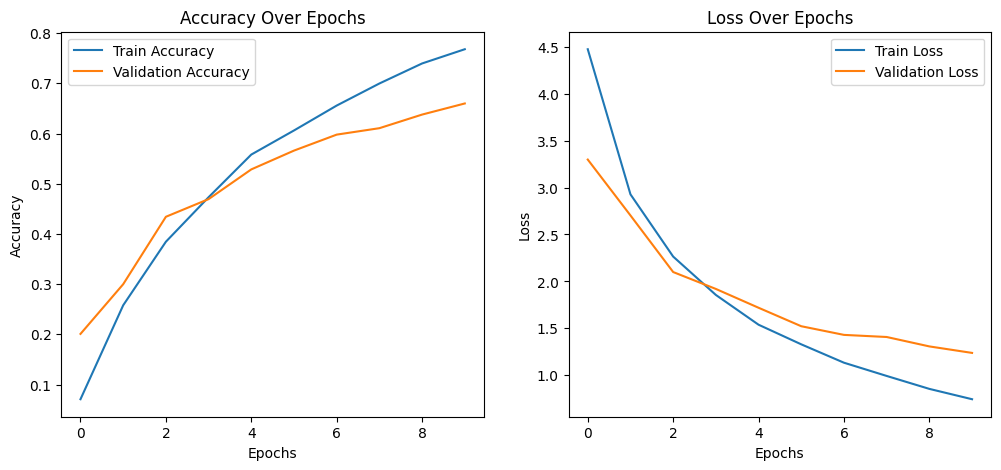

In [200]:
# פתיחת 25 השכבות האחרונות לאימון
for layer in model.layers[-25:]:
    layer.trainable = True

# קומפילציה מחדש עם קצב למידה נמוך
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# אימון מחדש עם Fine-Tuning
history_fine_tune = model.fit(
    train_dataset_augmented,
    validation_data=test_dataset,
    epochs=10
)

plot_history(history_fine_tune)

In [201]:
# prompt: save the model

# שמירת המודל
model.save('/content/drive/MyDrive/Car196_project/66_model.keras')


In [205]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Car196_project/66_model.keras')

In [206]:
# פתיחת 10 שכבות נוספות
for layer in model.layers[-35:]:
    layer.trainable = True

# קומפילציה מחדש עם קצב למידה קטן
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# הרצת Fine-Tuning עם 5-10 אפוקים
history_fine_tune = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3
)

Epoch 1/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.8489 - loss: 0.4786 - val_accuracy: 0.7419 - val_loss: 0.9674
Epoch 2/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8970 - loss: 0.3195 - val_accuracy: 0.7531 - val_loss: 0.9610
Epoch 3/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9057 - loss: 0.2690 - val_accuracy: 0.7526 - val_loss: 0.9503


In [140]:
# prompt: save the model

# שמירת המודל
model.save('/content/drive/MyDrive/Car196_project/52_model.keras')


In [141]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Car196_project/52_model.keras')